## Домашнее задание 2
* Обучить полносвязную модель на MNIST
* Обучить глубокую сверточную сеть на MNIST
* *обучить с нуля глубокую сеть на небольшом датасете. Сравнить результат с дообучением предобученной модели

Материалы занятия: https://github.com/BorisZH/reload_NN5/tree/master/lesson2, блокнот скопирован в lesson_02

В сети помог вот этот гайд:
https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-predict-new-samples-with-your-pytorch-model.md


In [9]:
import numpy
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

* архитектура модели + 
* загрузчик данных +
* формирование батча +
* инициализировать модель +
* оптимизатор +
* функция потерь +
* опционально шедулеры -
* трейн луп

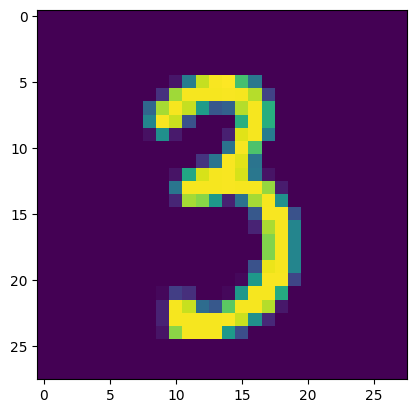

In [10]:
dataset = datasets.MNIST('.', download=True)
plt.imshow(dataset.data[98].detach().numpy())
plt.show()

In [11]:
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
len_train = len(train_set)
len_validate = len(val_set)
len_all = len(dataset)
print(f'Train set size: {len_train}, validate set size: {len_validate}, whole dataset size: {len_all}')

Train set size: 50000, validate set size: 10000, whole dataset size: 60000


In [12]:
# формирование батчка as is from the lesson
def collate_fn(data: list):
  # data = [(pic, target)...]
    pics = []
    target = []
    for item in data:
        pics.append(numpy.array(item[0]))
        if (len(item)>1):               # дорабатываю функцию для формирования batch без target
            target.append(item[1])
    pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
    if True:
        target = torch.from_numpy(numpy.array(target))
        return {
              'data': pics.view(pics.size(0), -1), # B x 7xx преобразуем матрицу 28х28 в вектор 7хх
            'target': target,
            }
    # else:
    #     return {
    #        'data': pics.view(pics.size(0), -1)
    #     }

In [13]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        # custom initsialisation nn.init.xavier_normal_(self.linear1.weight)
        self.do1 = nn.Dropout(dropout_p)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

        self.activation = nn.ReLU()

    def forward(self, x):
        # commented model from the lesson
        x = self.linear1(x)
        x = self.activation(x)
        x = self.do1(x)
        x = self.linear2(x)

        return x

In [14]:
# hyperparams
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}' # 'cuda:1' id GPU
n_epochs = 10
batch_size = 128

In [15]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
model.train()
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

In [16]:
def start_train(modell: nn.Module, collate_fnn):
    train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
    for epoch in range(n_epochs):
        dataloader_train = DataLoader(train_set,
                                batch_size,
                                shuffle=True,
                                collate_fn=collate_fnn,
                                drop_last = True,
                                )

        dataloader_test = DataLoader(val_set,
                                     batch_size,
                                     shuffle=True,
                                     collate_fn=collate_fnn,
                                     drop_last=True)

        for i, batch in enumerate(dataloader_train):
            optim.zero_grad()
            predict = modell(batch['data'].to(device))
            loss = loss_func(predict, batch['target'].to(device))
            loss.backward()
            optim.step()
            if i % 200 == 0:
                print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
        for j, batch_test in enumerate(dataloader_test):
            predict = modell(batch_test['data'].to(device))
            prediction = numpy.argmax(predict[0].detach().numpy())
            real_value = batch_test['target'][0]
            print(f'prediction: {prediction}, target: {real_value}')
start_train(model, collate_fn)

epoch: 0, step: 0, loss: 2.3025035858154297
epoch: 0, step: 200, loss: 0.2596690356731415
prediction: 3, target: 3
prediction: 0, target: 0
prediction: 5, target: 5
prediction: 3, target: 3
prediction: 6, target: 9
prediction: 6, target: 6
prediction: 9, target: 9
prediction: 9, target: 9
prediction: 0, target: 0
prediction: 8, target: 8
prediction: 5, target: 5
prediction: 3, target: 3
prediction: 9, target: 4
prediction: 9, target: 3
prediction: 1, target: 1
prediction: 6, target: 6
prediction: 3, target: 3
prediction: 9, target: 9
prediction: 9, target: 9
prediction: 0, target: 0
prediction: 0, target: 0
prediction: 0, target: 0
prediction: 4, target: 4
prediction: 4, target: 4
prediction: 7, target: 7
prediction: 5, target: 5
prediction: 1, target: 1
prediction: 8, target: 8
prediction: 1, target: 1
prediction: 2, target: 2
prediction: 4, target: 4
prediction: 4, target: 4
prediction: 4, target: 9
prediction: 7, target: 7
prediction: 3, target: 3
prediction: 7, target: 7
prediction

In [17]:

# # model.eval()
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
#
print(type(train_set))
print(type(val_set))
dataLoaderTest = DataLoader(train_set,
                                batch_size,
                                shuffle=True,
                                collate_fn=collate_fn,
                                drop_last = True,
                                )
b = True   # process just first for test
for aa in enumerate(dataLoaderTest):
    if not b:
        break
    torch.no_grad()
    result = model(aa)
    b = False

# item = dataset.__getitem__(2).__getitem__(0)
# l = list()
# l.append([item])
# list_test = collate_fn(l)
# model.eval()
# a = model()
# print(a)



<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataset.Subset'>


TypeError: linear(): argument 'input' (position 1) must be Tensor, not tuple